# CNN Autoencoder Image Inpainter

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

In [2]:
import os
import sys
import keras
import tarfile
import numpy as np
import urllib.request as urllib
import matplotlib.pyplot as plt
from keras.regularizers import l2
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.engine.training import Model
from keras import backend as K, regularizers
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Add, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
import scipy.io as sio
from keras.utils import to_categorical
import keras.models

In [3]:
from os.path import join
from google.colab import drive

# ROOT = "/content/drive"
# drive.mount(ROOT)

**Downloading the model through `wget`**

In [4]:
%%shell
rm -rf *
# getting the keras_model direc zipped file (>100 MB through wget)
wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Dki6AJan6sthZy9lfDWtvms3GN8rJPKW' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Dki6AJan6sthZy9lfDWtvms3GN8rJPKW" -O keras_model.zip && rm -rf /tmp/cookies.txt

# unzip under /content/ directory
unzip -q keras_model.zip

--2021-03-22 02:23:02--  https://docs.google.com/uc?export=download&confirm=NTcl&id=1Dki6AJan6sthZy9lfDWtvms3GN8rJPKW
Resolving docs.google.com (docs.google.com)... 172.217.12.238, 2607:f8b0:4004:807::200e
Connecting to docs.google.com (docs.google.com)|172.217.12.238|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-bc-docs.googleusercontent.com/docs/securesc/2v0f1prhhbmnr69poo1ul58123okm0h3/mhe3ngaikkaqfag5hc0vjpng2tdjivti/1616379750000/13881832785567679767/01518847431292372482Z/1Dki6AJan6sthZy9lfDWtvms3GN8rJPKW?e=download [following]
--2021-03-22 02:23:02--  https://doc-0o-bc-docs.googleusercontent.com/docs/securesc/2v0f1prhhbmnr69poo1ul58123okm0h3/mhe3ngaikkaqfag5hc0vjpng2tdjivti/1616379750000/13881832785567679767/01518847431292372482Z/1Dki6AJan6sthZy9lfDWtvms3GN8rJPKW?e=download
Resolving doc-0o-bc-docs.googleusercontent.com (doc-0o-bc-docs.googleusercontent.com)... 142.250.73.193, 2607:f8b0:4004:829::2001
Connecting to doc-0

## Load Data

In [5]:
# Configure based on dataset
batch_size = 10

tf = transforms.Compose([transforms.ToTensor()])

# split={'train', 'test', 'extra'} <- choose one size to download
dataset = datasets.SVHN('data', split='train', download=True, transform=tf)

In [6]:
val_size, test_size = 11000, 1000
train_size = len(dataset) - val_size - test_size
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
print(f'training size: {len(train_set)}')
print(f'val size: {len(val_set)}')
print(f'test size: {len(test_set)}')

training size: 61257
val size: 11000
test size: 1000


In [7]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=10, shuffle=True, drop_last = True)

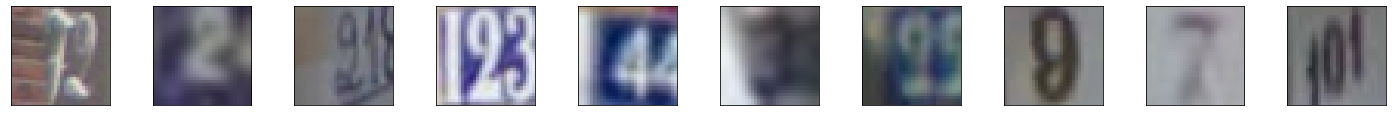

In [8]:
# Obtain batch of imgs from loader
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# Plot images as example
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
     ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
     plt.imshow(np.transpose(images[idx], (1, 2, 0)))

## Model Architecture

In [9]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class AutoencoderLarge(nn.Module):
    def __init__(self):
        super(AutoencoderLarge, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 5, stride=1, padding=2), # 32*32*32
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1), # 16*16*64
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), # 8*8*128
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1), # 4*4*256
            nn.ReLU(),
            nn.Conv2d(256, 1024, 4, stride=1, padding=0), # bottle neck: 1*1*1024
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, 256, 4, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 5, stride=1, padding=2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

## Training Helpers

**KERAS Get Accuracy Section**

In [11]:
from keras.preprocessing.image import ImageDataGenerator
# applying transformation to image
train_gen = ImageDataGenerator(
   rotation_range=15,
   zoom_range = 0.10,
   width_shift_range=0.3,
   height_shift_range=0.3,
   brightness_range=[0.2,1.0]
)


In [12]:
loaded_model = keras.models.load_model('/content/keras_model')

In [13]:
def get_accuracy_keras (model, data_loader, batch_size, blocking, verbose=False):
    '''
    get accuracy by randomly selecting 10 batches from the data_loader to speed up the training
    '''
    loss, accuracy = 0.0, 0.0
    samples = 0
    for i, (images, labels) in enumerate(data_loader):
        if i > 10:
            break
        ### preprocessing step to add masking to image batch###
        masked_imgs = images.detach().clone() # deep copy from images
        offset = blocking // 2 # offset fromt he center (16)
        masked_imgs[:, :, 16-offset: 16+offset, 16-offset: 16+offset] = 0 # block by setting all channels to 0
    
        ### to enable GPU usage ###
        if torch.cuda.is_available():
            images = images.cuda()
            masked_imgs = masked_imgs.cuda()
    
        outputs = model(masked_imgs)
    
        #KERAS part
        images = outputs.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()
        one_hot_labels = to_categorical(labels, 10)
        images = np.transpose(images, (0, 2, 3, 1))
        # Converting the arrays to Float type
        images = images.astype('float32')
        # Normalizing
        images = images / 255.0
        keras_batch = train_gen.flow(images, one_hot_labels, batch_size=batch_size)
        new_loss, new_accuracy = loaded_model.evaluate(keras_batch, verbose=verbose)

        loss += new_loss
        accuracy += new_accuracy
        samples += 1

    return loss/samples, accuracy/samples


In [14]:
import time
# for keep track of the best model weights
import copy
def evaluate(model, data_loader, criterion, blocking=8):
    total_loss = 0.0
    total_sample = 0

    for data in data_loader:
        images, _ = data

        ### preprocessing step to add masking to image batch###
        masked_imgs = images.detach().clone() # deep copy from images
        offset = blocking // 2 # offset fromt he center (16)
        masked_imgs[:, :, 16-offset: 16+offset, 16-offset: 16+offset] = 0 # block by setting all channels to 0

        ### to enable GPU usage ###
        if torch.cuda.is_available():
            images = images.cuda()
            masked_imgs = masked_imgs.cuda()

        outputs = model(masked_imgs)
        loss = criterion(outputs, images)
        total_loss += loss.item()
        total_sample += len(data)
    loss = total_loss / total_sample
    return loss

def train(model, batch_size=64, num_epochs=5, learning_rate=0.001, wd=1e-5,
          small=True, blocking=8, verbose=True):
    '''
    Main trainign function for CNN autoencoder.
    @wd: weight decay param for Adam optimizer
    @small: whether to use a small subset to train and verify for sanity check
    @blocking: size of blocking to apply at the center of the image (must <= 32)
    @verbose: whether to print out progress logs
    '''
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                               weight_decay=wd)

    # flag set whether to train on a small subset of the SVHN dataset
    if small:
        train_indices = np.random.randint(low=0, high=len(train_set), size=1000)
        val_indices = np.random.randint(low=0, high=len(val_set), size=200)
        test_indices = np.random.randint(low=0, high=len(test_set), size=200)
        train_set_small = torch.utils.data.Subset(train_set, train_indices)
        val_set_small = torch.utils.data.Subset(val_set, val_indices)
        test_set_small = torch.utils.data.Subset(test_set, test_indices)
        train_loader = torch.utils.data.DataLoader(train_set_small, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_set_small, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_set_small, batch_size=batch_size, shuffle=True)
        sample_rate = 10
    else:
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)
        sample_rate = 50

    ############### Trackers ################
    # train & validation loss trackers
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []
    # for visualizing the inpainting effectiveness (only log first 10 outputs)
    outputs_log = []
    # tracking the best model weights so far based on best accuaracy
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    iter = 0
    start_time = time.time()
    for epoch in range(1, num_epochs+1):
      
        for data in train_loader:
            images, _ = data
            optimizer.zero_grad()

            ### preprocessing step to add masking to image batch###
            masked_imgs = images.detach().clone() # deep copy from images
            offset = blocking // 2 # offset fromt he center (16)
            masked_imgs[:, :, 16-offset: 16+offset, 16-offset: 16+offset] = 0 # block by setting all channels to 0

            # visualize some of the masked images
            if not iter:
                num_images = masked_imgs.detach().clone().numpy()
                plt.figure(figsize=(3,3))
                imshow(num_images[2])

            ### to enable GPU usage ###
            if torch.cuda.is_available():
                images = images.cuda()
                masked_imgs = masked_imgs.cuda()
  
            outputs = model(masked_imgs)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()

            # track the training & validation loss
            if (iter+1) % sample_rate == 0:
                # log progress to the trackers
                train_loss.append(loss.item())
                val_loss.append(evaluate(model, val_loader, criterion, blocking))
                train_acc.append(get_accuracy_keras(model, train_loader, batch_size, blocking, False)[1])
                val_acc.append(get_accuracy_keras(model, val_loader, batch_size, blocking, False)[1])
                if verbose:
                    print('iter {}: train_acc: {:.4f}, train_loss: {:.4f} | val_acc: {:.4f}, val_loss: {:.4f} | e_time: {:.2f}s'.format(
                            iter+1, train_acc[-1], train_loss[-1], val_acc[-1], val_loss[-1], time.time() - start_time
                        ))

                # deep copy the model to track the weights yields the best classification accuracy on inpainted images
                if train_acc[-1] > best_acc:
                    best_acc = train_acc[-1]
                    best_model_wts = copy.deepcopy(model.state_dict())

            # log the first 10 batch of images along with reconstructed imgs for visualization
            if iter % 150 == 0 and iter <= 750:
                outputs_log.append((masked_imgs.cpu(), outputs.cpu()))

            iter += 1


    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # load the best model weights
    model.load_state_dict(best_model_wts)

    # evaluate on the testset
    test_loss = evaluate(model, test_loader, criterion)
    _, test_acc = get_accuracy_keras(model, test_loader, batch_size, blocking, False)
    print("Final test acc: {:.4f} | test loss: {:.4f}".format(
        test_acc, test_loss
    ))

    # Creates two subplots and unpacks the output array immediately
    n = len(train_loss) # number of samples
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    ax1.set_title("Multi-classifier Accuracy over Inpainted Images")
    ax1.plot(range(1,n+1), train_acc, label="Train")
    ax1.plot(range(1,n+1), val_acc, label="Validation")
    ax1.set_xlabel(f"Samplings (per 50 iters)")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc='best')
    ax2.set_title("Train vs Validation Loss")
    ax2.plot(range(1,n+1), train_loss, label="Train")
    ax2.plot(range(1,n+1), val_loss, label="Validation")
    ax2.set_xlabel(f"Samplings (per 50 iters)")
    ax2.set_ylabel("Loss")
    ax2.legend(loc='best')
    plt.show()

    return model, outputs_log
              

## Training Result

Training on GPU...
iter 50: train_acc: 0.1875, train_loss: 0.0142 | val_acc: 0.1960, val_loss: 0.0075 | e_time: 37.27s
iter 100: train_acc: 0.3991, train_loss: 0.0081 | val_acc: 0.3977, val_loss: 0.0050 | e_time: 41.82s
iter 150: train_acc: 0.5398, train_loss: 0.0078 | val_acc: 0.5284, val_loss: 0.0034 | e_time: 46.33s
iter 200: train_acc: 0.6051, train_loss: 0.0054 | val_acc: 0.5895, val_loss: 0.0028 | e_time: 50.83s
iter 250: train_acc: 0.6705, train_loss: 0.0050 | val_acc: 0.6733, val_loss: 0.0023 | e_time: 55.37s
iter 300: train_acc: 0.7571, train_loss: 0.0045 | val_acc: 0.7315, val_loss: 0.0020 | e_time: 59.94s
iter 350: train_acc: 0.7486, train_loss: 0.0033 | val_acc: 0.7401, val_loss: 0.0015 | e_time: 64.52s
iter 400: train_acc: 0.7756, train_loss: 0.0029 | val_acc: 0.7770, val_loss: 0.0013 | e_time: 69.32s
iter 450: train_acc: 0.8040, train_loss: 0.0021 | val_acc: 0.8253, val_loss: 0.0012 | e_time: 73.93s
iter 500: train_acc: 0.7841, train_loss: 0.0022 | val_acc: 0.7983, val_lo

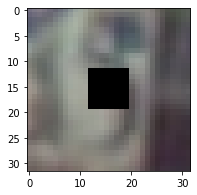

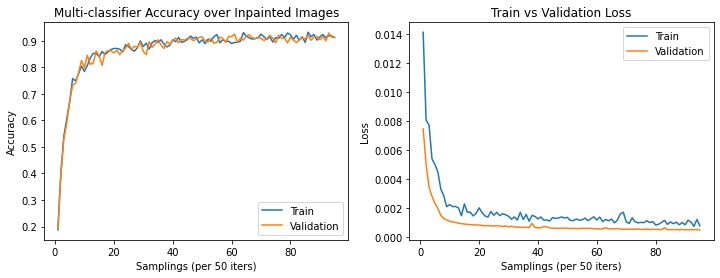

In [15]:
inpainter = Autoencoder()
if torch.cuda.is_available():
    inpainter.cuda()
    print('Training on GPU...')
else:
    print('GPU is not available. Training on CPU...')
inpainter, outputs_log = train(inpainter, batch_size=64, num_epochs=5, learning_rate=0.001,
                               wd=1e-5, small=False, blocking=8, verbose=True)

Training on GPU...
Finished Training
Total time elapsed: 659.71 seconds
Final test acc: 0.9020 | test loss: 0.0007


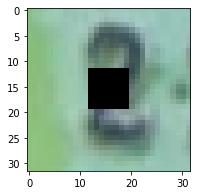

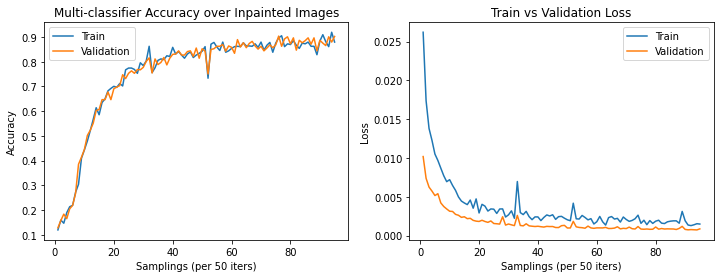

In [18]:
inpainter_lar = AutoencoderLarge()
if torch.cuda.is_available():
    inpainter_lar.cuda()
    print('Training on GPU...')
else:
    print('GPU is not available. Training on CPU...')
inpainter_lar, outputs_log_lar = train(inpainter_lar, batch_size=64, num_epochs=5, learning_rate=0.001,
                                   wd=1e-5, small=False, verbose=False)

## Visualizing Training Progress

Below is the result of trainign progress when setting "small" flag to True (1000 training size).

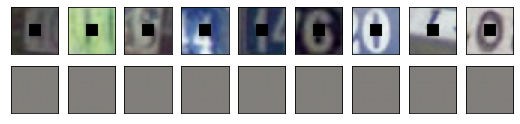

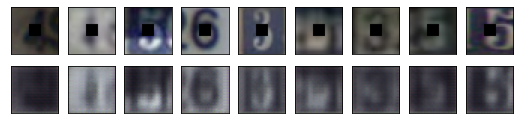

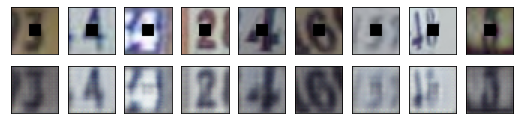

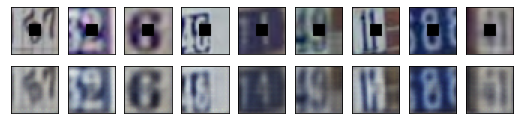

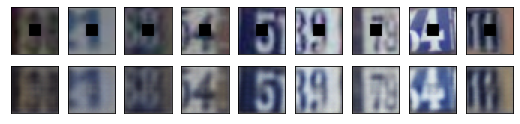

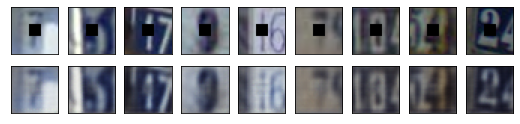

In [19]:
for k in range(0, len(outputs_log)):
    plt.figure(figsize=(9, 2))
    imgs = outputs_log[k][0].detach().numpy()
    recon = outputs_log[k][1].detach().numpy()
    for i, img in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1, xticks=[], yticks=[])
        imshow(img)
        
    for i, img in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1, xticks=[], yticks=[])
        imshow(img)

## Visualizing Result

In [20]:
def visualize_model(model, data_loader):
    # obtain one batch of test images
    dataiter = iter(data_loader)
    images, labels = dataiter.next()

    masked_imgs = images.detach().clone()
    masked_imgs[:, :, 12: 20, 12: 20] = 0
    
    # get sample outputs for display
    output = model(masked_imgs)
    # use detach when it's an output that requires_grad
    output = output.detach().numpy()

    # prep images for display
    images = images.numpy()

    # Plot input images
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(5):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        imshow(images[idx])
    
    # Plot result images
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(5):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        imshow(output[idx])

batch_size = 10
torch.manual_seed(0)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

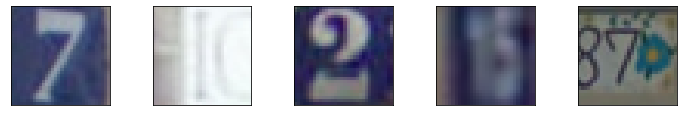

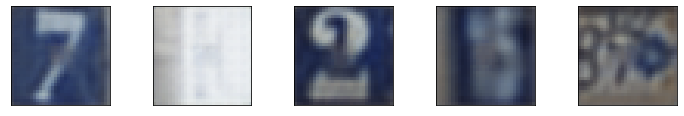

In [21]:
# Sam's model
visualize_model(inpainter.cpu(), test_loader)

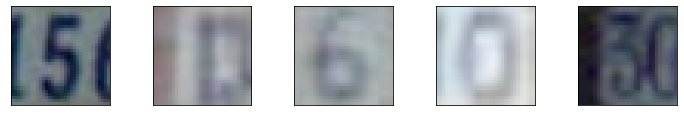

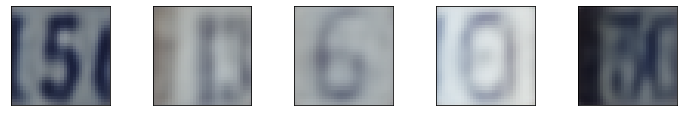

In [22]:
# large Conv autoencoder based on Standford paper
visualize_model(inpainter_lar.cpu(), test_loader)